In [37]:
#|default_exp dataset

In [38]:
#| export
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torch
import pandas as pd
import numpy as np
from copy import deepcopy
from datasets import  load_from_disk
from scipy.interpolate import interp1d
from sklearn.preprocessing import RobustScaler
import sys
sys.path.append('/opt/slh/icecube/')

In [39]:
from pdb import set_trace
import seaborn as sns
class CFG:
    CACHE_PATH = Path('../data/cache')

In [40]:
fns = list((CFG.CACHE_PATH/'batch_3').glob('*.pth'))

In [41]:
# | export
# function that loads the data from the pth file and return the data and the label as pd.DataFrame
def load_data(
    fn: Path,
    columns_event: str = ["time", "charge", "auxiliary", "x", "y", "z"],
    columns_label: str = ["azimuth", "zenith"],
    keep_auxiliary_event: bool = False,
):
    data = torch.load(fn)
    event = pd.DataFrame.from_records(data["event"])[columns_event]
    if keep_auxiliary_event:
        event = event.query("auxiliary == True")
    label = pd.DataFrame.from_records(data["target"])[columns_label]
    return event.astype(np.float32), label


class IceCubeCasheDatasetV0(Dataset):
    def __init__(self, fns, max_events=100):
        self.fns = fns
        self.max_events = max_events

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


class IceCubeCasheDatasetV1(Dataset):
    """_summary_

    Args:
        Dataset (_type_): Same as IceCubeCasheDatasetV0 but with the option to keep the auxiliary events
    """

    def __init__(self, fns, max_events=100, keep_auxiliary_event: bool = True):
        self.fns = fns
        self.max_events = max_events
        self.keep_auxiliary_event = keep_auxiliary_event

    def __len__(self):
        return len(self.fns)

    def __getitem__(self, idx):
        fn = self.fns[idx]
        event, label = load_data(fn, keep_auxiliary_event=self.keep_auxiliary_event)

        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = torch.tensor(event.values)
        mask = torch.ones(len(event), dtype=torch.bool)
        label = torch.tensor(label.values, dtype=torch.float32)

        return {"event": event, "mask": mask, "label": label}


# collate_fn that pads the event and mask to the max length in the batch using pythorch pad_sequence
class HuggingFaceDatasetV0(Dataset):
    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        event["time"] /= event["time"].max()
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])

        event = event.values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


# function to normalize input between 1 and 0
def normalize(x):
    return (x - x.min()) / (x.max() - x.min())


class HuggingFaceDatasetV1(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        # feature engineering
        event["w1"] = event["charge"] * event["time"]
        event["w0"] = event["charge"] - event["w1"]

        event["wx0"] = event.x * event.w0
        event["wy0"] = event.y * event.w0
        event["wz0"] = event.z * event.w0
        event["wx1"] = event.x * event.w1
        event["wy1"] = event.y * event.w1
        event["wz1"] = event.z * event.w1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "w1",
                "w0",
                "wx0",
                "wy0",
                "wz0",
                "wx1",
                "wy1",
                "wz1",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV2(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV3(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch

class HuggingFaceDatasetV4(Dataset):
    """
    Same as HuggingFaceDatasetV0 but returns sensor_id as well
    in addition it adds + 1 to make the sensor_id start from 1 instead of 0,
    0 is ignore index


    """

    def __init__(self, ds, max_events=160):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        # this is done in order to shift sensor id from 0 to 1
        # since paddding index is 0
        sensor_id = event["sensor_id"].values + 1

        event["charge"] = np.log10(event["charge"])

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


def event_filtering_v1(batch, max_pulse_count=128, t_valid_length=6199.700247193777):
    col = batch.columns
    t_peak = batch["time"][batch["charge"].argmax()]
    t_valid_min = t_peak - t_valid_length
    t_valid_max = t_peak + t_valid_length
    t_valid = (batch["time"] > t_valid_min) * (batch["time"] < t_valid_max)
    batch["rank"] = 2 * (1 - batch["auxiliary"]) + (t_valid)
    batch = batch.sort_values(by=["rank", "charge"])
    # pick-up from backward
    batch = batch[-max_pulse_count:]
        # resort by time
    batch = batch.sort_values(by="time")
    return batch[col]

def event_filtering_v2(batch, max_pulse_count=128, t_valid_length=6199.700247193777):
    "same as v1 but we add rank column to every entry and sort only if lenth is more then max_pulse_count"
    t_peak = batch["time"][batch["charge"].argmax()]
    t_valid_min = t_peak - t_valid_length
    t_valid_max = t_peak + t_valid_length
    t_valid = (batch["time"] > t_valid_min) * (batch["time"] < t_valid_max)
    batch["rank"] = 2 * (1 - batch["auxiliary"]) + (t_valid)
    if batch.shape[0] > max_pulse_count:
        batch = batch.sort_values(by=["rank", "charge"])
        # pick-up from backward
        batch = batch[-max_pulse_count:]
            # resort by time
        batch = batch.sort_values(by="time")
    return batch
        
        

class HuggingFaceDatasetV5(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        event["time"] /= event["time"].max()
        
        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"])
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


In [42]:
#ds = IceCubeCasheDatasetV1(fns)
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn)
# for x in dl:
#     break

In [43]:
ds = HuggingFaceDatasetV5(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))

In [44]:
#| export
def ice_transparency(
    data_path="/opt/slh/icecube/data/ice_transparency.txt", datum=1950
):
    # Data from page 31 of https://arxiv.org/pdf/1301.5361.pdf
    # Datum is from footnote 8 of page 29
    df = pd.read_csv(data_path, delim_whitespace=True)
    df["z"] = df["depth"] - datum
    df["z_norm"] = df["z"] / 500
    df[["scattering_len_norm", "absorption_len_norm"]] = RobustScaler().fit_transform(
        df[["scattering_len", "absorption_len"]]
    )

    # These are both roughly equivalent after scaling
    f_scattering = interp1d(df["z_norm"], df["scattering_len_norm"])
    f_absorption = interp1d(df["z_norm"], df["absorption_len_norm"])
    return f_scattering, f_absorption

def prepare_sensors():
    sensors = pd.read_csv('/opt/slh/icecube/data/sensor_geometry.csv').astype(
        {
            "sensor_id": np.int16,
            "x": np.float32,
            "y": np.float32,
            "z": np.float32,
        }
    )
    sensors["string"] = 0
    sensors["qe"] = 1

    for i in range(len(sensors) // 60):
        start, end = i * 60, (i * 60) + 60
        sensors.loc[start:end, "string"] = i

        # High Quantum Efficiency in the lower 50 DOMs - https://arxiv.org/pdf/2209.03042.pdf (Figure 1)
        if i in range(78, 86):
            start_veto, end_veto = i * 60, (i * 60) + 10
            start_core, end_core = end_veto + 1, (i * 60) + 60
            sensors.loc[start_core:end_core, "qe"] = 1.35

    # https://github.com/graphnet-team/graphnet/blob/b2bad25528652587ab0cdb7cf2335ee254cfa2db/src/graphnet/models/detector/icecube.py#L33-L41
    # Assume that "rde" (relative dom efficiency) is equivalent to QE
    sensors["x"] /= 500
    sensors["y"] /= 500
    sensors["z"] /= 500
    sensors["qe"] -= 1.25
    sensors["qe"] /= 0.25

    return sensors.set_index("sensor_id")[['qe']]


def convert_to_3d(azimuth, zenith):
    """Converts zenith and azimuth to 3D direction vectors"""
    x = np.cos(azimuth) * np.sin(zenith)
    y = np.sin(azimuth) * np.sin(zenith)
    z = np.cos(zenith)
    return np.array([x, y, z], dtype=np.float32)


class HuggingFaceDatasetV6(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetV7(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch



class HuggingFaceDatasetV8(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=148):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    



class HuggingFaceDatasetV9(Dataset):
    """
    dataset with event filtering up to 128


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    
class HuggingFaceDatasetV10(Dataset):
    """
    same as V9 but with 148 


    """

    def __init__(self, ds, max_events=148):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    
class HuggingFaceDatasetV11(Dataset):
    """
    same as V9 but with added sensoor ids 


    """

    def __init__(self, ds, max_events=128):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        sensor_id = event["sensor_id"].values + 1
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch

class HuggingFaceDatasetV12(Dataset):
    """
    same as V9 but with added sensoor ids , same as V11 but with 160 `max_len`


    """

    def __init__(self, ds, max_events=160):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        sensor_id = event["sensor_id"].values + 1
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    
    
class HuggingFaceDatasetV13(Dataset):
    """
    same as V9 but with added sensoor ids , same as V11 but with 196 `max_len`


    """

    def __init__(self, ds, max_events=196):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()

        if event.shape[0] > self.max_events:
            event = event_filtering_v1(event, max_pulse_count=self.max_events)

        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["auxiliary"] -= 0.5

        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] = self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        sensor_id = event["sensor_id"].values + 1
        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "qe",
                "scattering",
                "absorption",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        #print(item["azimuth"], item["zenith"])

        batch = deepcopy(
            {
                "event": torch.tensor(event, dtype=torch.float32),
                "sensor_id": torch.tensor(sensor_id, dtype=torch.int32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch
    
    
class HuggingFaceDatasetV14(Dataset):
    """
    same as V9 but with 148, returning qe and aux as long tesnors 


    """

    def __init__(self, ds, max_events=148):
        self.ds = ds
        self.max_events = max_events
        self.f_scattering, self.f_absorption = ice_transparency()
        self.sensor_data = prepare_sensors()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
                "sensor_id"
            ]
        ].astype(np.float32)
        t = (event["time"].values - 1.0e04) / 3.0e4
        event["time"] /= event["time"].max()


        event = event_filtering_v2(event, max_pulse_count=self.max_events)
        event[["x", "y", "z"]] /= 500
        event["charge"] = np.log10(event["charge"]) / 3.0
        event["time"] = t[: self.max_events]
        event["scattering"] = self.f_scattering(event["z"].values).reshape(-1)
        event["absorption"] = self.f_absorption(event["z"].values).reshape(-1)
        event['qe'] =  self.sensor_data.loc[event['sensor_id'].values].values.reshape(-1)
        mask = np.ones(len(event), dtype=bool)
        label = convert_to_3d(item["azimuth"], item["zenith"])
        batch = deepcopy(
            {
                "event" : torch.tensor(event[["x", "y", "z", "time", "charge", "scattering", "absorption"]].values, dtype=torch.float32),
                "rank": torch.tensor(event['rank'].values, dtype=torch.long),
                "qe": torch.tensor(event['qe'].values + 1, dtype=torch.long),
                "aux": torch.tensor(event['auxiliary'].values, dtype=torch.long,),
                "label": torch.tensor(label),
                "mask": torch.tensor(mask)
            }
        )
        return batch

In [45]:
ds = HuggingFaceDatasetV14(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))

In [46]:

from icecube.utils import collate_fn_v2

In [47]:
from torch_geometric.data import Data

In [48]:
# | export


# pytorch function that takes [n, x, y, z] tensor and calculates the distance between each point and returns [n x n] matrix using torch.cdist
def get_distance_matrix(xyz):
    return torch.cdist(xyz, xyz)


def get_distance_matrix_for_indices(dm, indices):
    return dm[indices][:, indices]


def get_distance_matrix_from_csv(
    path_to_geom="/opt/slh/icecube/data/sensor_geometry.csv",
):
    geom = pd.read_csv(path_to_geom)[["x", "y", "z"]]
    geom = torch.tensor(geom.values, dtype=torch.float32)
    geom = get_distance_matrix(geom)
    # nromalize goematry matrix
    geom = geom / geom.max()
    return geom


class HuggingFaceDatasetGraphV0(Dataset):
    def __init__(self, ds, min_adj_distance=0.015, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.geom_max = np.array([576.37, 509.5, 524.56])
        self.geom_min = np.array([[-570.9, -521.08, -512.82]])
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)

        # in this way the time start at 0 and end at 1
        event["time"] = 1 - normalize(event["time"])
        if self.max_events:
            event = event[: self.max_events]

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event[["x", "y", "z"]] = (event[["x", "y", "z"]].values - self.geom_min) / (
            self.geom_max - self.geom_min
        )

        event["charge"] = np.log10(event["charge"])

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch


class HuggingFaceDatasetGraphV1(Dataset):
    def __init__(self, ds, min_adj_distance=0.05, max_events=100):
        self.ds = ds
        self.max_events = max_events
        self.mad = min_adj_distance
        self.distance_matrix_ = get_distance_matrix_from_csv()

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        item = self.ds[idx]

        event = pd.DataFrame(item)[
            [
                "sensor_id",
                "time",
                "charge",
                "auxiliary",
                "x",
                "y",
                "z",
            ]
        ].astype(np.float32)
        if self.max_events:
            event = event[: self.max_events]
        # in this way the time start at 0 and end at 1
        event["time"] = (event['time'] - 1.0e04) / 3.0e4

        # normalize the x,y,z coordinates of geomatry
        # TO DO add this in to preprocessing
        event['x'] /=500
        event['y'] /=500
        event['z'] /=500

        event["charge"] = np.log10(event["charge"])/3.0

        # getting distance matrix for event
        distance_matrix = get_distance_matrix_for_indices(
            self.distance_matrix_, event["sensor_id"].values
        )

        dmx = torch.zeros((self.max_events, self.max_events), dtype=torch.float32)
        dmx[: distance_matrix.shape[0], : distance_matrix.shape[1]] = distance_matrix
        adjecent_matrix = (dmx < self.mad).type(torch.float32)

        event = event[
            [

                "charge",
                "auxiliary",
                "time",
                "x",
                "y",
                "z",
            ]
        ].values
        mask = np.ones(len(event), dtype=bool)
        label = np.array([item["azimuth"], item["zenith"]], dtype=np.float32)

        batch = deepcopy(
            {
                "distance_matrix": dmx,
                "adjecent_matrix": adjecent_matrix,
                "event": torch.tensor(event, dtype=torch.float32),
                "mask": torch.tensor(mask),
                "label": torch.tensor(label),
            }
        )
        return batch




<AxesSubplot:>

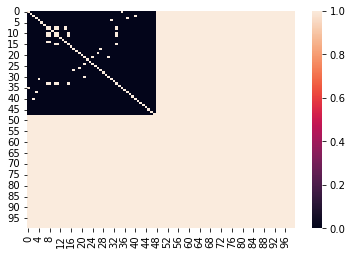

In [49]:
ds = HuggingFaceDatasetGraphV1(load_from_disk('/opt/slh/icecube/data/hf_cashe/batch_1.parquet'))
sns.heatmap(ds[np.random.randint(0, len(ds))]['adjecent_matrix'].numpy())
#dl = DataLoader(ds, batch_size=64, shuffle=True, num_workers=4, collate_fn=collate_fn_graphv0)
#for x in dl:
#     break

In [50]:
#| export
def good_luck():
    return True

In [51]:
#|hide
#|eval: false
from nbdev.doclinks import nbdev_export
nbdev_export()

In [ ]:
# class IceCubeKaggle():
#     """`Detector` class for Kaggle Competition."""

#     # Implementing abstract class attribute

#     def _forward(self, data: Data) -> Data:
#         """Ingest data, build graph, and preprocess features.
#         Args:
#             data: Input graph data.
#         Returns:
#             Connected and preprocessed graph data.
#         """
#         # Check(s)
#         self._validate_features(data)

#         # Preprocessing
#         data.x[:, 0] /= 500.0  # x
#         data.x[:, 1] /= 500.0  # y
#         data.x[:, 2] /= 500.0  # z
#         data.x[:, 3] = (data.x[:, 3] - 1.0e04) / 3.0e4  # time
#         data.x[:, 4] = torch.log10(data.x[:, 4]) / 3.0  # charge

#         return data

# class Direction(Label):
#     """Class for producing particle direction/pointing label."""

#     def __init__(
#         self, azimuth_key: str = "azimuth", zenith_key: str = "zenith"
#     ):
#         """Construct `Direction`."""
#         self._azimuth_key = azimuth_key
#         self._zenith_key = zenith_key

#     def __call__(self, graph: Data) -> torch.tensor:
#         """Compute label for `graph`."""
#         x = torch.cos(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         y = torch.sin(graph[self._azimuth_key]) * torch.sin(
#             graph[self._zenith_key]
#         ).reshape(-1, 1)
#         z = torch.cos(graph[self._zenith_key]).reshape(-1, 1)
#         return torch.cat((x, y, z), dim=1)